In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

In [3]:
def dN(x):
    return math.exp(-0.5*x**2)/math.sqrt(2*math.pi)

def N(d):
    return quad(lambda x:dN(x),-20,d,limit=50)[0]

def d1f(St, K, t, T, r, sigma):
    d1 = (math.log(St / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * math.sqrt(T - t))
    return d1

def BSM_call_value(St, K, t, T, r, sigma):
    d1=d1f(St,K,t,T,r,sigma)
    d2=d1-sigma*math.sqrt(T-t)
    call_value = St * N(d1) - math.exp(-r * (T - t)) * K * N(d2)
    return call_value

def BSM_put_value(St, K, t, T, r, sigma):
    put_value = BSM_call_value(St,K,t,T,r,sigma)-St + math.exp(-r * (T - t)) * K
    return put_value

In [4]:
def BSM_delta (St, K, t, T, r, sigma):
    d1=d1f(St, K, t, T, r, sigma)
    delta=N(d1)
    return delta

def BSM_gamma(St, K, t, T, r, sigma):
    d1=d1f(St, K, t, T, r, sigma)
    gamma=dN(d1) / (St * sigma*math.sqrt(T-t))
    return gamma

def BSM_theta(St, K, t, T, r,sigma): #轉成正值
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    theta = -(St * dN(d1) * sigma / (2 * math.sqrt(T - t))
              + r * K * math.exp(-r * (T - t)) * N(d2))
    return -theta

def BSM_rho(St, K, t, T, r, sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    rho = K * (T - t) * math.exp(-r * (T - t)) * N(d2)
    return rho

def BSM_vega(St, K, t, T, r, sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    vega = St * dN(d1) * math.sqrt(T - t)
    return vega

def BSM_vanna(St, K, t, T, r, sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    return dN(d1) * (-d2) / sigma

In [5]:
n = norm.pdf
N = norm.cdf

def bs(cp_flag, S, K, r, q, T, sigma):
    d1 = (np.log(S / K) + (r - q + (sigma ** 2) * 0.5) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == 'c':
        price = S * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)
    else:
        price = K * np.exp(-r * T) * N(-d2) - S * np.exp(-q * T) * N(-d1)
    return price

def bs_diff(cp_flag, S, K, r, q, T, sigma):
    d1 = (np.log(S / K) + (r - q + (sigma ** 2) * 0.5) * T) / (sigma * np.sqrt(T))
    return S * np.sqrt(T) * n(d1)

def find_vol(target_value, call_put, S, K, T, r, q):
    MAX_ITERATIONS = 1000
    PRECISION = 1.0e-10

    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs(call_put, S, K, r, q, T, sigma)
        bs_dif = bs_diff(call_put, S, K, r, q, T, sigma)

        price = price
        diff = target_value - price  # our root

#         print (i, sigma, diff)

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/bs_dif # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

In [6]:
vol = lambda p_list, strike, cp : [find_vol(p_list[i], cp, S, strike[i], T, r, q) for i in range(len(strike))]

In [7]:
K = np.linspace(-1, 1, 13) * 300 + 11000
call_b = [341, 297, 256, 217, 180, 145, 114, 87, 63, 44, 29.5, 18.5, 11.5]
call_a = [345, 305, 259, 219, 181, 147, 115, 88, 65, 45, 30, 19, 12]
put_b = [27.5, 34, 42, 52, 64, 80, 98, 121, 148, 178, 213, 251, 295]
put_a = [28, 34.5, 43, 54, 66, 81, 99, 123, 149, 181, 216, 256, 300]

In [8]:
# S = 11010 * np.exp(- r * T)
r = 0.01
T = 1 / 52
q = 0

In [9]:
S = 11010 * np.exp(r * T)
call_b_v = vol(call_b, K, 'c')
call_a_v = vol(call_a, K, 'c')
put_b_v = vol(put_b, K, 'p')
put_a_v = vol(put_a, K, 'p')

In [10]:
voll = pd.DataFrame([call_b_v, call_a_v, put_b_v, put_a_v])

In [11]:
voll.columns = K

In [12]:
voll

10700.0   10750.0   10800.0   10850.0   10900.0   10950.0   11000.0  \
0  0.210507  0.202741  0.198280  0.193545  0.187938  0.180951  0.175311   
1  0.221143  0.221442  0.204648  0.197402  0.189724  0.184333  0.176956   
2  0.212337  0.205585  0.198695  0.192003  0.184740  0.179637  0.172404   
3  0.213683  0.206776  0.200827  0.195869  0.188320  0.181329  0.174049   

    11050.0   11100.0   11150.0   11200.0   11250.0   11300.0  
0  0.170273  0.163648  0.158504  0.154306  0.149649  0.147546  
1  0.171928  0.167111  0.160406  0.155408  0.151010  0.149304  
2  0.167365  0.162350  0.155180  0.149331  0.140547  0.139339  
3  0.170674  0.164084  0.160903  0.156004  0.154440  0.156987

In [13]:
vola = pd.DataFrame(voll.apply(lambda x: x.sort_values().values).iloc[[1,2], :].mean()).transpose()

In [14]:
vola

10700.0   10750.0   10800.0   10850.0   10900.0  10950.0  11000.0  \
0  0.21301  0.206181  0.199761  0.194707  0.188129  0.18114  0.17468   

    11050.0   11100.0   11150.0   11200.0   11250.0   11300.0  
0  0.170474  0.163866  0.159455  0.154857  0.150329  0.148425

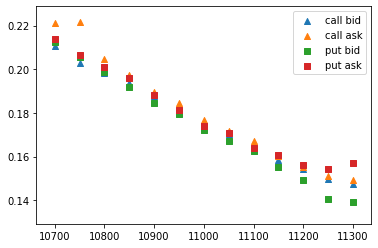

In [43]:
plt.figure()
plt.scatter(K, call_b_v, marker='^', label='call bid')
plt.scatter(K, call_a_v, marker='^', label='call ask')
plt.scatter(K, put_b_v, marker='s', label='put bid')
plt.scatter(K, put_a_v, marker='s', label='put ask')
plt.legend()

In [ ]:
vega = [BSM_vega(S, K[i], 0, T, r, vola.iloc[0, i]) for i in range(len(K))]

In [ ]:
vega

# 1

In [17]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [209]:
x = K.reshape(-1, 1)
y = np.array(vola)[0]

In [210]:
svr = SVR(kernel='rbf', C=1e2, gamma='auto', epsilon=1e-4, max_iter=1e5).fit(x, y)
yfit = svr.predict(x)

In [211]:
# # svr = SVR(kernel='poly', degree=2, C=1e3, gamma='auto', epsilon=1e-4).fit(x, y)
# svr = SVR(kernel='poly', degree=3, C=1e1, gamma='auto', epsilon=1e-3, max_iter=1e7).fit(x, y)
# yfit = svr.predict(x)

In [212]:
yfit

array([0.21309676, 0.20575225, 0.19966864, 0.19484226, 0.1882191 ,
       0.18132183, 0.17434773, 0.17024551, 0.1641526 , 0.15979063,
       0.15496425, 0.15061968, 0.14809256])

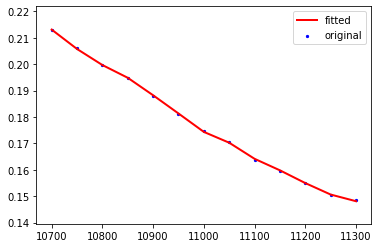

In [213]:
plt.scatter(x, y, s=5, color="blue", label="original")
plt.plot(x, yfit, lw=2, color="red", label="fitted")
plt.legend()
plt.show()

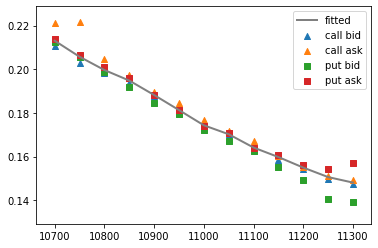

In [214]:
plt.figure()
plt.scatter(K, call_b_v, marker='^', label='call bid')
plt.scatter(K, call_a_v, marker='^', label='call ask')
plt.scatter(K, put_b_v, marker='s', label='put bid')
plt.scatter(K, put_a_v, marker='s', label='put ask')
plt.plot(x, yfit, lw=2, color="gray", label="fitted")
plt.legend()

# 2

In [69]:
x = np.concatenate((K, K)).reshape(-1, 1)
y = np.array(voll.apply(lambda x: x.sort_values().values).iloc[[1,2], :]).reshape(1, -1)[0]

In [100]:
svr = SVR(kernel='rbf', C=1e-1, gamma='auto', epsilon=1e-3, max_iter=1e5).fit(x, y)
yfit = svr.predict(x)

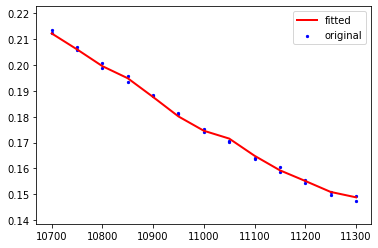

In [101]:
plt.scatter(x, y, s=5, color="blue", label="original")
plt.plot(x[:13], (yfit[:13]+yfit[13:])/2, lw=2, color="red", label="fitted")
plt.legend()
plt.show()

In [169]:
svr.set_params

<bound method BaseEstimator.set_params of SVR(C=1000.0, epsilon=0.0001, gamma='auto', max_iter=100000.0)>

# 3

In [219]:
x = K.reshape(-1, 1)
y = np.array(vola)[0]

In [224]:
choose = [0, 2, 4, 6, 8, 10, 12]
xc = x[choose]
yc = y[choose]

In [228]:
svr = SVR(kernel='rbf', C=1e2, gamma='auto', epsilon=1e-4, max_iter=1e5).fit(xc, yc)
yfit = svr.predict(xc)

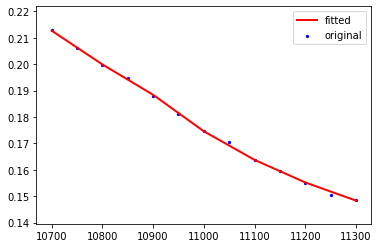

In [229]:
plt.scatter(x, y, s=5, color="blue", label="original")
plt.plot(xc, yfit, lw=2, color="red", label="fitted")
plt.legend()
plt.show()

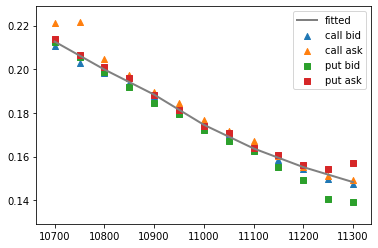

In [230]:
plt.figure()
plt.scatter(K, call_b_v, marker='^', label='call bid')
plt.scatter(K, call_a_v, marker='^', label='call ask')
plt.scatter(K, put_b_v, marker='s', label='put bid')
plt.scatter(K, put_a_v, marker='s', label='put ask')
plt.plot(xc, yfit, lw=2, color="gray", label="fitted")
plt.legend()

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
N = 1000    
def makeData(x):    
    r = [a/10 for a in x]
    y = np.sin(x)+np.random.uniform(-.5, .2, len(x))
    return np.array(y+r)

x = [i/100 for i in range(N)]
y = makeData(x)
x = np.array(x).reshape(-1,1)

plt.scatter(x, y, s=5, color="blue")
plt.show()

In [ ]:
x

In [ ]:
y

In [ ]:
svr = SVR().fit(x, y)

In [ ]:
yfit = svr.predict(x)


In [ ]:
yfit

In [ ]:
plt.scatter(x, y, s=5, color="blue", label="original")
plt.plot(x, yfit, lw=2, color="red", label="fitted")
plt.legend()
plt.show()

In [ ]:
score = svr.score(x,y)
print("R-squered:", score)
print("MSE:", mean_squared_error(y, yfit))